# RIMORPHIS Workflow

To run this workflow, you must sign up for [Google Earth Engine](https://signup.earthengine.google.com/#!/), and enter an authentication code to initialize it. 

In [1]:
!pip install geemap

### Import Libraries


In [2]:
from glob import glob
import os

import hydrofunctions as hf
import earthpy as et
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import folium
import matplotcheck.notebook as nb
from matplotcheck.base import PlotTester
import matplotcheck.autograde as ag
import numpy as np


# Installs geemap package
import geemap.eefolium as geemap

# We are adding this for you as there is a bug in hydrofunctions that
# Turns off plotting
%matplotlib inline

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Authenticates and initializes Earth Engine
import ee

### Authenticate Google Earth Engine

In [3]:
ee.Authenticate()
ee.Initialize()  

Enter verification code: 4/1AX4XfWjepHUwJzRO4bNAAR5pyvCiy3Z_1QlzPyPJzrqPT8wFIvrNPPEIPMo

Successfully saved authorization token.


# Overarching functions:
- input river
- input time series
- feed both into GEE and NWIS

# Site Info for All Gage Sites

Specify the start and end time for time series as well as geographic region to process. This can be changed to river gages and time periods.

In [4]:
#site number for NWIS gage (Vicksburg MS Site)
site_no = ['07289000']

#Coordinates for the bounds of a rectangle at Vicksburg MS
xMin = -91.2
yMin = 32
xMax = -90.8
yMax = 32.7

# Vicksburg MS wet and dry seasons
wet_season_start = '2019-03-15'
wet_season_end = '2019-05-01'

dry_season_start = '2019-9-01'
dry_season_end = '2019-10-01'

#site number for NWIS gage (Yankton SD Site)
site_no_gp = ['06467500']

#Coordinates for the bounds of a rectangle at Yankton SD (Gavins Point)
xMin_gp = -97.7
yMin_gp = 42.2
xMax_gp = -97.3
yMax_gp = 43.2

# Yankton SD wet and dry seasons
wet_season_start_gp = '2021-05-02'
wet_season_end_gp = '2021-08-01'

dry_season_start_gp = '2021-02-01'
dry_season_end_gp = '2021-05-01'

#site number for NWIS gage (Pine Bluff AR Site)
site_no_ar = ['07263650']

#Coordinates for the bounds of a rectangle at Pine Bluff AR
xMin_ar = -92.4
yMin_ar = 34
xMax_ar = -91.7
yMax_ar = 34.4

# Pine Bluff AR wet and dry seasons
wet_season_start_ar = '2019-05-15'
wet_season_end_ar = '2019-06-15'

dry_season_start_ar = '2019-09-01'
dry_season_end_ar = '2019-12-01'

# Google Earth Engine

In [64]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
Map

In [65]:
Map_gp = geemap.Map(center=[42.8,-97.5], zoom= 11)
Map_gp

In [66]:
Map_ar = geemap.Map(center=[34.2,-92], zoom= 11)
Map_ar

### GEE Script for Vicksburg MS

In [8]:
# Import the Sentinel 2 collection as sentinel 2
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

rectangleGeoJSON = ee.Geometry.Rectangle(
  [
    [xMin, yMin],
    [xMax, yMax]   # max x and y
  ]
)

miss_bnds = ee.FeatureCollection([
    ee.Feature(
        rectangleGeoJSON,
        {'name': 'Mississippi Vicksburg', 'fill': 1}),
    ])

dry_season = sentinel2.filterBounds(miss_bnds).filterDate(dry_season_start, dry_season_end).mosaic().clip(miss_bnds)

wet_season = sentinel2.filterBounds(miss_bnds).filterDate(wet_season_start, wet_season_end).mosaic().clip(miss_bnds)


# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
waterPalette = ['red', 'yellow', 'green', 'blue'];
#print(miss_bnds)


### Display Earth Engine True Color Images layers in Dry Season - Vicksburg MS

In [70]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 12)
Map.addLayer(dry_season, trueColor_palette, '2019 Dry season true color');
Map.addLayerControl()
Map

### Display Earth Engine True Color Images layers in Wet Season

In [69]:
Map = geemap.Map(center=[32.3,-90.9], zoom= 12)
Map.addLayer(wet_season, trueColor_palette, '2019 Wet season true color');
Map.addLayerControl()
Map

### GEE Script for Yankton SD

In [11]:
# Import the Sentinel 2 collection as sentinel 2

rectangleGeoJSON_gp = ee.Geometry.Rectangle(
  [
    [xMin_gp, yMin_gp],
    [xMax_gp, yMax_gp]   # max x and y
  ]
)

gp_bnds = ee.FeatureCollection([
    ee.Feature(
        rectangleGeoJSON_gp,
        {'name': 'South Dakota Yankton', 'fill': 1}),
    ])

dry_season_gp = sentinel2.filterBounds(gp_bnds).filterDate(dry_season_start_gp, dry_season_end_gp).mosaic().clip(gp_bnds)

wet_season_gp = sentinel2.filterBounds(gp_bnds).filterDate(wet_season_start_gp, wet_season_end_gp).mosaic().clip(gp_bnds)

# Calculate NDWI                  
#ndwi_dry = image_dry.normalizedDifference(['B3', 'B8']);
#ndwi_wet = image_wet.normalizedDifference(['B3', 'B8']);

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
waterPalette = ['red', 'yellow', 'green', 'blue'];
#print(miss_bnds)


### Display Earth Engine True Color Images layers in Dry Season - Yankton SD

In [71]:
Map = geemap.Map(center=[42.8,-97.5], zoom= 11)
Map.addLayer(dry_season_gp, trueColor_palette, '2019 Dry season true color');
Map.addLayerControl()
Map

### Display Earth Engine True Color Images layers in Wet Season - Yankton SD

In [13]:
Map = geemap.Map(center=[42.8,-97.5], zoom= 11)
Map.addLayer(wet_season_gp, trueColor_palette, '2019 Wet season true color');
Map.addLayerControl()
Map

### GEE Script for Pine Bluff AR

In [14]:
# Import the Sentinel 2 collection as sentinel 2

rectangleGeoJSON_ar = ee.Geometry.Rectangle(
  [
    [xMin_ar, yMin_ar],
    [xMax_ar, yMax_ar]   # max x and y
  ]
)

ar_bnds = ee.FeatureCollection([
    ee.Feature(
        rectangleGeoJSON_ar,
        {'name': 'Pine Bluff, AR', 'fill': 1}),
    ])

dry_season_ar = sentinel2.filterBounds(ar_bnds).filterDate(dry_season_start_ar, dry_season_end_ar).mosaic().clip(ar_bnds)

wet_season_ar = sentinel2.filterBounds(ar_bnds).filterDate(wet_season_start_ar, wet_season_end_ar).mosaic().clip(ar_bnds)

# Calculate NDWI                  
#ndwi_dry = image_dry.normalizedDifference(['B3', 'B8']);
#ndwi_wet = image_wet.normalizedDifference(['B3', 'B8']);

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
waterPalette = ['red', 'yellow', 'green', 'blue'];
#print(miss_bnds)


### Display Earth Engine True Color Images layers in Dry Season - Pine Bluff AR

In [72]:
Map = geemap.Map(center=[34.2,-92], zoom= 11)
Map.addLayer(dry_season_ar, trueColor_palette, '2019 Dry season true color');
Map.addLayerControl()
Map

### Display Earth Engine True Color Images layers in Wet Season - Pine Bluff AR

In [73]:
Map = geemap.Map(center=[34.2,-92], zoom= 11)
Map.addLayer(wet_season_ar, trueColor_palette, '2019 Wet season true color');
Map.addLayerControl()
Map

# Hydrofunctions

In [17]:
# In this cell create a function to support figure one that opens
# data using hydrofunctions and returns a dataframe  with
# x,y location, site name and discharge data

def create_df(site, start, end):
    """Imports data to dataframe, adds geolocation and stream gage site name

    Parameters
    ----------
    site : string
        Site number as specified by USGS
        
    start : string
        Desired start date for data
        
    end : string
        Desired end date for data 

    Returns
    -------
    response_df : dataframe
        Dataframe created from downloaded csv    """
    
    # YOUR CODE HERE
    
    # Generate dataframe from NWIS for gage discharge data at specified sites
    response = hf.NWIS(site, 'dv', start, end, parameterCd='00060')
    response_df = response.df()

    # Rename columns for discharge and flags
    response_df.columns = ('discharge', 'qualifiers')
    
    # Add column for site name
    response_df["sitename"] = hf.get_nwis_property(response.json, key='siteName')[0]
   
    # Add columns for gage location latitude and longitude
    geolocation =   hf.get_nwis_property(response.json, key='geoLocation')[0]
    response_df["latitude"] = geolocation["geogLocation"]["latitude"]
    response_df["longitude"] = geolocation["geogLocation"]["longitude"]

    
    return response_df

def create_df_gageht(site, start, end):
    """Imports data to dataframe, adds geolocation and stream gage site name

    Parameters
    ----------
    site : string
        Site number as specified by USGS
        
    start : string
        Desired start date for data
        
    end : string
        Desired end date for data 

    Returns
    -------
    response_df : dataframe
        Dataframe created from downloaded csv    """
    
    # YOUR CODE HERE
    
    # Generate dataframe from NWIS for gage discharge data at specified sites
    response = hf.NWIS(site, 'dv', start, end, parameterCd='00065')
    response_df = response.df()

    # Rename columns for discharge and flags
    response_df.columns = ('gage ht', 'qualifiers')
    
    # Add column for site name
   # response_df["sitename"] = hf.get_nwis_property(response.json, key='siteName')[0]
   
    # Add columns for gage location latitude and longitude
    #geolocation =   hf.get_nwis_property(response.json, key='geoLocation')[0]
    #response_df["latitude"] = geolocation["geogLocation"]["latitude"]
    #response_df["longitude"] = geolocation["geogLocation"]["longitude"]

    
    return response_df


# Create dataframe from NWIS site - Vicksburg MS

In [18]:
site_df = create_df(site_no, wet_season_start, wet_season_end)

site_df 

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07289000&parameterCd=00060&startDT=2019-03-15&endDT=2019-05-01


,discharge,qualifiers,sitename,latitude,longitude
datetimeUTC,,,,,
2019-03-15 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-16 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-17 00:00:00+00:00,1870000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-18 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-19 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-20 00:00:00+00:00,1860000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-21 00:00:00+00:00,1850000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-22 00:00:00+00:00,1850000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-03-23 00:00:00+00:00,1840000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833


[Text(0.5, 0, 'Date (Month-Day)'),
 Text(0, 0.5, 'Daily Mean Stream Discharge \n (cu. ft. / second)')]

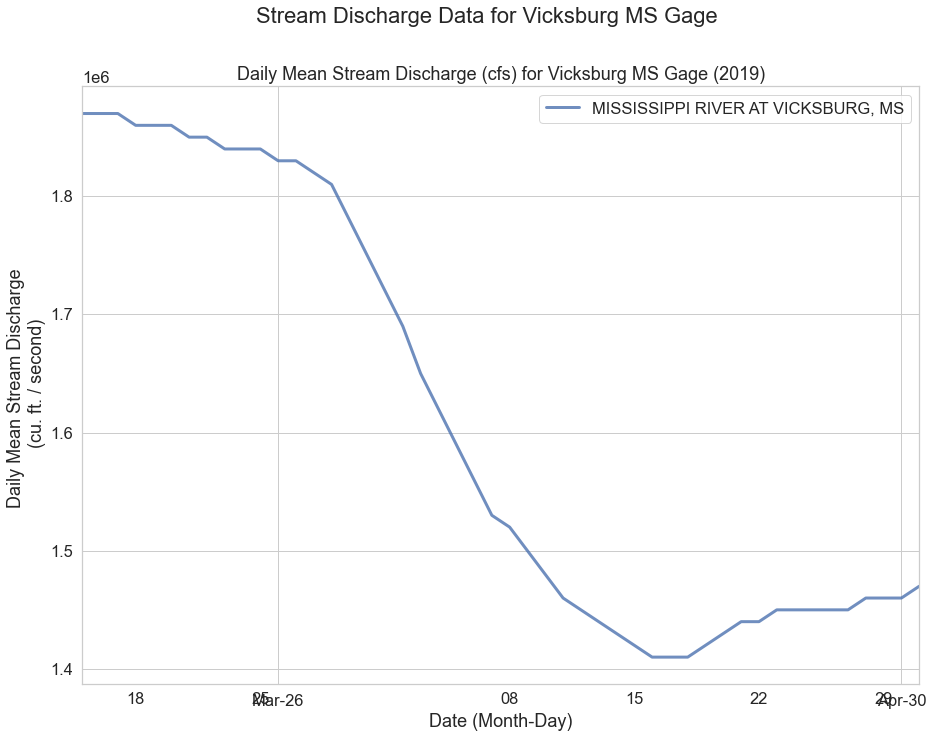

In [19]:
# Define plot space, overall size and title
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 11))

fig.suptitle(
    "Stream Discharge Data for Vicksburg MS Gage", fontsize=22)

# Loop for plotting Subplot 1
for site_name, group in site_df.groupby('sitename'):
    group.groupby('sitename').plot(y='discharge',
                                   title="Daily Mean Stream Discharge (cfs) for Vicksburg MS Gage (2019)",
                                   label=site_name,
                                   linewidth=3.0,
                                   ax=ax1,
                                   alpha=.8)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Stream Discharge \n (cu. ft. / second)")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

# Create dataframe from NWIS site - Yankton SD

In [20]:
site_df_gp = create_df_gageht(site_no_gp, dry_season_start_gp, wet_season_end_gp)

site_df_gp

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06467500&parameterCd=00065&startDT=2021-02-01&endDT=2021-08-01


,gage ht,qualifiers
datetimeUTC,,
2021-02-01 00:00:00+00:00,9.57,A
2021-02-02 00:00:00+00:00,9.50,A
2021-02-03 00:00:00+00:00,9.56,A
2021-02-04 00:00:00+00:00,9.57,A
2021-02-05 00:00:00+00:00,9.77,A
...,...,...
2021-07-28 00:00:00+00:00,11.44,A
2021-07-29 00:00:00+00:00,11.46,A
2021-07-30 00:00:00+00:00,11.44,A


[Text(0.5, 0, 'Date (Month-Day)'),
 Text(0, 0.5, 'Daily Mean Gage Height \n (ft)')]

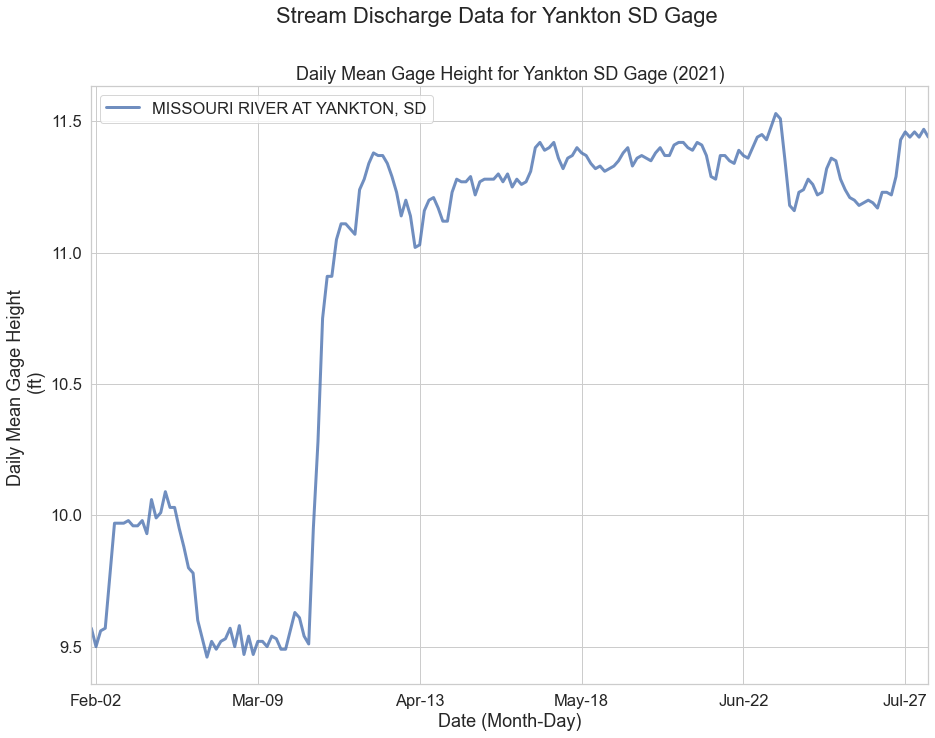

In [21]:
# Define plot space, overall size and title
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 11))

fig.suptitle(
    "Stream Discharge Data for Yankton SD Gage", fontsize=22)

# Loop for plotting Subplot 1
site_df_gp.plot(y='gage ht',
                title="Daily Mean Gage Height for Yankton SD Gage (2021)",
                label='MISSOURI RIVER AT YANKTON, SD',
                linewidth=3.0,
                ax=ax1,
                alpha=.8)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

# Create dataframe from NWIS site - Pine Bluff AR

In [22]:
site_df_ar = create_df_gageht(site_no_ar, wet_season_start_ar, dry_season_end_ar)

site_df_ar

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07263650&parameterCd=00065&startDT=2019-05-15&endDT=2019-12-01


,gage ht,qualifiers
datetimeUTC,,
2019-05-15 00:00:00+00:00,37.14,A
2019-05-16 00:00:00+00:00,36.94,A
2019-05-17 00:00:00+00:00,36.23,A
2019-05-18 00:00:00+00:00,35.73,A
2019-05-19 00:00:00+00:00,35.72,A
...,...,...
2019-11-27 00:00:00+00:00,31.56,A
2019-11-28 00:00:00+00:00,31.47,A
2019-11-29 00:00:00+00:00,31.53,A


[Text(0.5, 0, 'Date (Month-Day)'),
 Text(0, 0.5, 'Daily Mean Gage Height \n (ft)')]

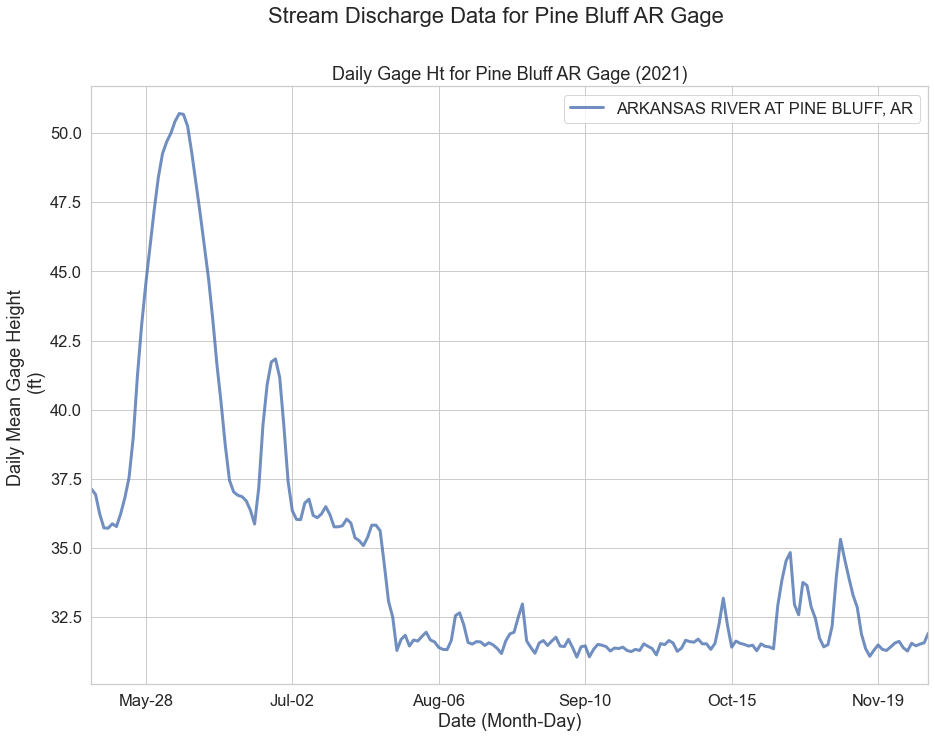

In [23]:
# Define plot space, overall size and title
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 11))

fig.suptitle(
    "Stream Discharge Data for Pine Bluff AR Gage", fontsize=22)

# Loop for plotting Subplot 1
site_df_ar.plot(y='gage ht',
                title="Daily Gage Ht for Pine Bluff AR Gage (2021)",
                label='ARKANSAS RIVER AT PINE BLUFF, AR',
                linewidth=3.0,
                ax=ax1,
                alpha=.8)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

# NWDI Analysis - MS River

### Display Earth Engine the NDWI images with a color palette in Dry Season

In [74]:
dry_season_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
ndwi_dry = dry_season.normalizedDifference(['B3', 'B8']);
dry_season_Map.addLayer(ndwi_dry, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Wet season NDWI');
dry_season_Map

### Display Earth Engine the NDWI images with a color palette in Wet Season

In [75]:
wet_season_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)
ndwi_wet = wet_season.normalizedDifference(['B3', 'B8']);
wet_season_Map.addLayer(ndwi_wet, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Wet season NDWI');
wet_season_Map

# NWDI Analysis - MO River at Yankton SD

### Display Earth Engine the NDWI images with a color palette in Dry Season

In [26]:
dry_season_Map_gp = geemap.Map(center=[42.8,-97.5], zoom= 11)
ndwi_dry_gp = dry_season_gp.normalizedDifference(['B3', 'B8']);
dry_season_Map_gp.addLayer(ndwi_dry_gp, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2021 Dry season NDWI');
dry_season_Map_gp

### Display Earth Engine the NDWI images with a color palette in Wet Season

In [27]:
wet_season_Map_gp = geemap.Map(center=[42.8,-97.5], zoom= 11)
ndwi_wet_gp = wet_season_gp.normalizedDifference(['B3', 'B8']);
wet_season_Map_gp.addLayer(ndwi_wet_gp, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2021 Wet season NDWI');
wet_season_Map_gp

# NWDI Analysis - Arkansas River at Pine Bluff AR

### Display Earth Engine the NDWI images with a color palette in Dry Season

In [76]:
dry_season_Map_ar = geemap.Map(center=[34.2,-92], zoom= 11)
ndwi_dry_ar = dry_season_ar.normalizedDifference(['B3', 'B8']);
dry_season_Map_ar.addLayer(ndwi_dry_ar, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Dry season NDWI');
dry_season_Map_ar

### Display Earth Engine the NDWI images with a color palette in Wet Season

In [29]:
wet_season_Map_ar = geemap.Map(center=[34.2,-92], zoom= 11)
ndwi_wet_ar = wet_season_ar.normalizedDifference(['B3', 'B8']);
wet_season_Map_ar.addLayer(ndwi_wet_ar, {'min': -1, 'max': 0.5, 'palette': waterPalette}, '2019 Wet season NDWI');
wet_season_Map_ar

# Extract Water Pixels

In [30]:
water_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)

ndwi_threshold = 0
water_image = ndwi_wet.gt(ndwi_threshold).selfMask()

water_Map.addLayer(water_image, {'palette': 'blue'}, 'Water image')
water_Map

In [78]:
water_Map_dry = geemap.Map(center=[32.3,-90.9], zoom= 11)

ndwi_threshold = 0
water_image_dry = ndwi_dry.gt(ndwi_threshold).selfMask()

water_Map_dry.addLayer(water_image_dry, {'palette': 'blue'}, 'Water image')
water_Map_dry

In [79]:
water_Map_gp = geemap.Map(center=[42.8,-97.5], zoom= 11)

ndwi_threshold_gp = 0
water_image_gp = ndwi_wet_gp.gt(ndwi_threshold_gp).selfMask()

water_Map_gp.addLayer(water_image_gp, {'palette': 'blue'}, 'Water image')
water_Map_gp

In [80]:
water_Map_gp_dry = geemap.Map(center=[42.8,-97.5], zoom= 11)

ndwi_threshold_gp = 0
water_image_gp_dry = ndwi_dry_gp.gt(ndwi_threshold_gp).selfMask()

water_Map_gp_dry.addLayer(water_image_gp, {'palette': 'blue'}, 'Water image')
water_Map_gp_dry

In [81]:
water_Map_ar = geemap.Map(center=[34.2,-92], zoom= 11)

ndwi_threshold_ar = 0
water_image_ar_dry = ndwi_dry_ar.gt(ndwi_threshold_ar).selfMask()

water_Map_ar.addLayer(water_image_ar_dry, {'palette': 'blue'}, 'Water image')
water_Map_ar

In [82]:
water_Map_ar = geemap.Map(center=[34.2,-92], zoom= 11)

ndwi_threshold_ar = 0
water_image_ar_wet = ndwi_wet_ar.gt(ndwi_threshold_ar).selfMask()

water_Map_ar.addLayer(water_image_ar_wet, {'palette': 'blue'}, 'Water image')
water_Map_ar


In [63]:
# Reduce the region. The region parameter is the Feature geometry.
countDictionary_wet = water_image_ar_wet.reduceRegion(**{
  'reducer': ee.Reducer.count(),
  'geometry': ar_bnds.geometry(),
  'scale': 10,
  'maxPixels': 1e9
})

# Reduce the region. The region parameter is the Feature geometry.
countDictionary_dry = water_image_ar_dry.reduceRegion(**{
  'reducer': ee.Reducer.count(),
  'geometry': ar_bnds.geometry(),
  'scale': 10,
  'maxPixels': 1e9
})

# The result is a Dictionary.  Print it.
print(countDictionary_wet.getInfo())
print(countDictionary_dry.getInfo())

{'nd': 857159}
{'nd': 690287}


# Transfer from Raster to Vector

In [47]:
vector_Map = geemap.Map(center=[32.3,-90.9], zoom= 11)

In [48]:
water_vector = water_image.reduceToVectors(scale=30, maxPixels=60000000, geometry = rectangleGeoJSON)
vector_Map.addLayer(water_vector, {}, 'Water vector')
vector_Map
